# DA FARE:

Creare colonna in meteo con ore di luce come differenza tra sunset e sunrise\
Creare colonna per pioggia (0/1)

In [13]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from fbprophet import Prophet

In [14]:
#per vedere i grafici nel codice
%matplotlib inline
plt.rcParams['figure.figsize']= (15,7.5)

# Dati giornalieri e settimanali (con weekend)

In [15]:
u1_agg = pd.read_csv('./u1_we_agg.txt')

In [16]:
u1_h = u1_agg.set_index(pd.DatetimeIndex(u1_agg['T']))

In [17]:
u1_d = u1_h.resample('D').mean()

In [18]:
u1_w = u1_h.resample('W').mean()

In [19]:
meteo = pd.read_csv("./milan_owm_2021-05-04-0829.csv")
meteo = meteo[["timestamp", "temperature", "humidity", "sunrise", "sunset", "status"]]
meteo = meteo.rename(columns={"timestamp": "T"})
meteo = meteo.set_index(pd.DatetimeIndex(meteo['T']))

### ATTENZIONE
Con il resample il meteo ha solo le colonne numeriche (temperatura e unidità)\
ffill() perchè d ha 116 Nan e w ne ha 8

In [24]:
meteo_d = meteo.resample('D').mean().ffill() 

In [25]:
meteo_w = meteo.resample('W').mean().ffill() 

In [28]:
#u1_w = u1_w.drop(columns="temperature")
u1_w_comp = u1_w.merge(meteo_w, on="T")
u1_w_comp = u1_w_comp.rename(columns={"CONSUMO_ATTIVA_PRELEVATA": "Consumi_original"})
u1_w_comp

,Consumi_original,temperature,humidity
T,,,
2018-01-07,71.972143,4.998586,86.006258
2018-01-14,81.837321,6.454437,90.265000
2018-01-21,82.646071,4.243509,78.627673
2018-01-28,85.991607,4.929725,85.414268
2018-02-04,81.431250,4.825327,94.225131
...,...,...,...
2020-12-06,57.027679,3.456023,92.470514
2020-12-13,52.162143,5.009134,97.372647
2020-12-20,54.510893,6.559637,95.435544


# Prophet

Crea colonne adatte a Prophet

In [37]:
dummy = u1_h[['Consumi_original']]
dummy = dummy.reset_index()
dummy.columns = ['ds','y']

dummy.tail()
m.fit()
m.plot_components()

KeyError: "None of [Index(['Consumi_original'], dtype='object')] are in the [columns]"

In [39]:
dummy = u1_w_comp[['Consumi_original']]
dummy = dummy.reset_index()
dummy.columns = ['ds','y']

dummy.tail()

,ds,y
152,2020-12-06,57.027679
153,2020-12-13,52.162143
154,2020-12-20,54.510893
155,2020-12-27,55.963393
156,2021-01-03,54.566875


In [40]:
m = Prophet ()
m.fit(dummy)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Crea le date da prevedere

In [41]:
future = m.make_future_dataframe(periods=120)     #crea solo le date
future.tail()

,ds
272,2021-04-29
273,2021-04-30
274,2021-05-01
275,2021-05-02
276,2021-05-03


In [42]:
forecast = m.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
272,2021-04-29,56.493892,47.292424,65.414029
273,2021-04-30,56.416179,47.104062,65.379161
274,2021-05-01,56.378680,47.074881,64.742769
275,2021-05-02,56.378446,47.553682,65.229454
276,2021-05-03,56.412262,47.616589,66.294311


In [58]:
m.plot?

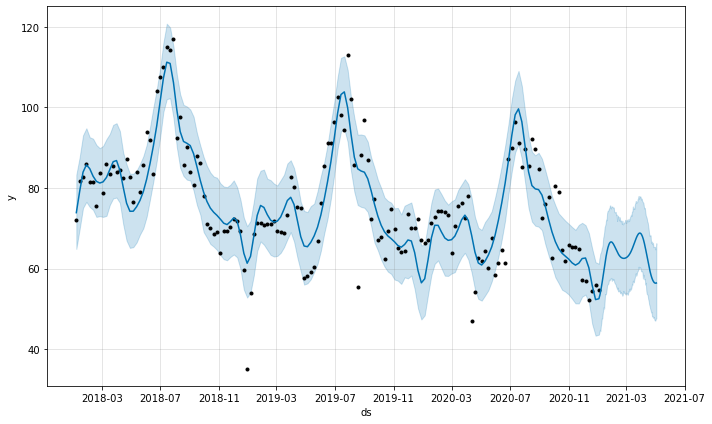

In [57]:
m.plot(forecast);

In [59]:
u1_fix["y"] < u1_fix["yhat_lower"]

KeyError: 'y'

In [65]:
u1_fix[50:60]

,ds,y,yhat,yhat_lower,yhat_upper
50,2018-12-23,59.686786,63.815494,54.792947,72.649347
51,2018-12-30,35.181786,61.317234,52.799656,70.491926
52,2019-01-06,54.041250,63.035049,54.061577,71.825256
53,2019-01-13,68.595893,68.073259,58.344398,76.714247
54,2019-01-20,71.274107,73.208037,64.355614,82.371212
55,2019-01-27,71.231964,75.662535,66.717606,84.281200
56,2019-02-03,70.787500,75.169507,65.933390,84.566473
57,2019-02-10,71.061250,73.388860,64.668230,82.316312
58,2019-02-17,70.939821,72.011123,63.393141,81.931492
59,2019-02-24,71.802143,71.536643,62.988357,81.074128


In [64]:
u1_fix = dummy.merge(forecast[['yhat','yhat_lower',"yhat_upper","ds"]], on="ds")
u1_fix[u1_fix["y"] < u1_fix["yhat_lower"]]

,ds,y,yhat,yhat_lower,yhat_upper
51,2018-12-30,35.181786,61.317234,52.799656,70.491926
52,2019-01-06,54.041250,63.035049,54.061577,71.825256
80,2019-07-21,94.441250,103.852079,94.631040,112.670002
84,2019-08-18,55.506429,84.753364,75.766686,93.221186
118,2020-04-12,47.043452,68.279803,59.073434,77.568363
119,2020-04-19,54.124405,64.077843,54.845993,72.798891
125,2020-05-31,58.423214,68.245832,59.704450,77.548789
126,2020-06-07,61.390774,72.005777,62.954855,81.251568
127,2020-06-14,64.532738,76.323645,67.223832,85.524408
128,2020-06-21,61.327083,81.150467,71.901567,90.403610


In [44]:
u1_fix = dummy.merge(forecast[['yhat','yhat_lower',"yhat_upper","ds"]], on="ds")
u1_fix["Consumi"] = np.where(u1_fix["y"] < u1_fix["yhat_lower"], u1_fix["yhat_lower"], u1_fix["y"])
u1_fix.head()

,ds,y,yhat,yhat_lower,yhat_upper,Consumi
0,2018-01-07,71.972143,73.872676,64.873206,83.283248,71.972143
1,2018-01-14,81.837321,79.153696,69.836095,87.646221,81.837321
2,2018-01-21,82.646071,83.917625,75.026839,93.074338,82.646071
3,2018-01-28,85.991607,85.745241,76.561593,94.822785,85.991607
4,2018-02-04,81.431250,84.799689,75.285025,92.592419,81.431250


In [45]:
u1_fix = u1_fix.drop(["yhat","y","yhat_lower","yhat_upper"], axis=1)

In [ ]:
plt.plot(u1_w_comp["Consumi_original"])

In [ ]:
plt.plot(u1_fix["Consumi"])

In [ ]:
u1_fix = u1_fix.rename(columns={"ds": "T"})
u1_new = u1_fix.merge(u1_w_comp[["temperature","humidity"]], on="T")
u1_new

In [ ]:
u1_new.to_csv('./u1_sett.csv', index = False, header=True)